# Let us begin writing our code for the business problem "Entertainment Center Classification
# in Indian Cities.
# Kindly follow the report for each step/code section. Comments added to code will enhance
# readability.
# Let us begin by webscraping the datasource

In [4]:
# importing required modules 
import re
import requests
import sys
import json
# Import the Beautiful Soup Library
from bs4 import BeautifulSoup,NavigableString
# Import the plotting library
import matplotlib.pyplot as plt
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
from geopy.geocoders import Nominatim # import free python library for geocoding
#install folium
#!conda install -c conda-forge folium=0.5.0 --yes
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
# install wordcloud
#!python -m pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 366 kB 27.0 MB/s eta 0:00:01


In [5]:
#Let us first try and webscrap the dataset that we require.
#Using a try-catch block because connectivity dependancies can result in errors.
try:
	URL="https://en.wikipedia.org/wiki/List_of_cities_in_India_by_population"
	req = requests.get(URL)
	html_data = req.text
	beautiful_soup=BeautifulSoup(html_data,"html5lib")
	t_row = beautiful_soup.find("table").find("tbody").find_all("tr") #get all the rows in the table
except:
	print("Error occured")
	
#declare a dataframe having two columns
t_frame = pd.DataFrame(columns=["City" , "Population"])

In [6]:
counter = 0
for row in t_row:
	
	#Lets skip the first row in the table as it contains data which is of no use to us
	if counter == 0:
		counter = 1
		continue
	
	#This finds all the data in each row
	data = row.find_all('td')
	city = data[1].get_text(separator=" ").strip() # In the second data of each row, get the city name
	city = city.split()[0]
	population = data[2].get_text(separator=" ").strip() # In the third data of each row get the population of city as per 2011 census(latest available)
	population = population.replace(',','') 
	#print(population)
	
	t_frame = t_frame.append({
						"City" : city,
						"Population" : population
			},ignore_index=True)

In [7]:
print(t_frame.dtypes)	 #We see that both the columns are of object datatype  
t_frame = t_frame.astype({
'Population' : int
}) #Typecasting the population column into integer datatype

City          object
Population    object
dtype: object


In [8]:
print(t_frame.head())

        City  Population
0     Mumbai    12442373
1      Delhi    11007835
2  Bangalore     8436675
3  Hyderabad     6809970
4  Ahmedabad     5570585


In [9]:
print(t_frame.shape)

(319, 2)


In [10]:
t_frame = t_frame.sort_values(
						by = "Population",
						ascending = False
						)
						
print(t_frame)	#Now the dataframe is sorted in a descending order on the Population column

           City  Population
0        Mumbai    12442373
1         Delhi    11007835
2     Bangalore     8436675
3     Hyderabad     6809970
4     Ahmedabad     5570585
..          ...         ...
314      Tezpur      102505
315   Jehanabad      102456
316  Aurangabad      101520
317     Gangtok      100286
318       Vasco      100000

[319 rows x 2 columns]


In [11]:
india_df = pd.DataFrame(columns=["City" , "Population"])
for ci,pop in zip(t_frame["City"],t_frame['Population']):
	if pop >= 1000000:
		india_df = india_df.append({
						"City" : ci,
						"Population" : pop
			},ignore_index=True) #This ensures that we work only with cities having population above 1,000,000
	else:
		break;
		
print(india_df)

                City Population
0             Mumbai   12442373
1              Delhi   11007835
2          Bangalore    8436675
3          Hyderabad    6809970
4          Ahmedabad    5570585
5            Chennai    4681087
6            Kolkata    4486679
7              Surat    4467797
8               Pune    3115431
9             Jaipur    3046163
10           Lucknow    2815601
11            Kanpur    2767031
12            Nagpur    2405665
13            Indore    1960631
14             Thane    1818872
15            Bhopal    1795648
16     Visakhapatnam    1730320
17  Pimpri-Chinchwad    1727692
18             Patna    1684222
19          Vadodara    1670806
20         Ghaziabad    1648643
21          Ludhiana    1618879
22              Agra    1585704
23            Nashik    1486053
24            Ranchi    1456528
25         Faridabad    1414050
26            Meerut    1305429
27            Rajkot    1286678
28   Kalyan-Dombivli    1247327
29       Vasai-Virar    1222390
30      

# Now we need the coordinate values in our dataset. We have already discussed in report
# that we will use a free python library, Nominatim to help us get the city coordinates
# The coordinates received will be of roughly the area around the city center

In [12]:
coord_frames = pd.DataFrame(columns=["City" , "Latitude", "Longitude"])
geolocator = Nominatim(user_agent="capstone") #lets get the coordinates of cities using Nominatim 
for ci in zip(india_df["City"]):
	
	ci=ci[0]
	loc = geolocator.geocode(ci+","+"India")
	lat = loc.latitude
	lon = loc.longitude
	print(ci)
	coord_frames = coord_frames.append({
								"City" : ci,
								"Latitude" : lat,
								"Longitude" : lon
	},ignore_index=True) #Now we have a dataframe consisting of the city name along with their latitude and longitude

Mumbai
Delhi
Bangalore
Hyderabad
Ahmedabad
Chennai
Kolkata
Surat
Pune
Jaipur
Lucknow
Kanpur
Nagpur
Indore
Thane
Bhopal
Visakhapatnam
Pimpri-Chinchwad
Patna
Vadodara
Ghaziabad
Ludhiana
Agra
Nashik
Ranchi
Faridabad
Meerut
Rajkot
Kalyan-Dombivli
Vasai-Virar
Varanasi
Srinagar
Aurangabad
Dhanbad
Amritsar
Navi
Allahabad
Howrah
Gwalior
Jabalpur
Coimbatore
Vijayawada
Jodhpur
Madurai
Raipur
Kota


In [13]:
print(coord_frames)

                City   Latitude  Longitude
0             Mumbai  19.075990  72.877393
1              Delhi  28.651718  77.221939
2          Bangalore  12.979120  77.591300
3          Hyderabad  17.360589  78.474061
4          Ahmedabad  23.021624  72.579707
5            Chennai  13.083694  80.270186
6            Kolkata  22.572672  88.363882
7              Surat  21.186461  72.808128
8               Pune  18.521428  73.854454
9             Jaipur  26.915458  75.818982
10           Lucknow  26.838100  80.934600
11            Kanpur  26.460914  80.321759
12            Nagpur  21.149813  79.082056
13            Indore  22.720362  75.868200
14             Thane  19.194329  72.970178
15            Bhopal  23.258486  77.401989
16     Visakhapatnam  17.723128  83.301284
17  Pimpri-Chinchwad  18.627929  73.800983
18             Patna  25.609324  85.123525
19          Vadodara  22.297314  73.194257
20         Ghaziabad  28.711241  77.444537
21          Ludhiana  30.909016  75.851601
22         

In [14]:
city_data = pd.merge(india_df,coord_frames, on="City")
print(city_data) #This is a merged datagframe containing the cities with their population,latitude and longitude

                City Population   Latitude  Longitude
0             Mumbai   12442373  19.075990  72.877393
1              Delhi   11007835  28.651718  77.221939
2          Bangalore    8436675  12.979120  77.591300
3          Hyderabad    6809970  17.360589  78.474061
4          Ahmedabad    5570585  23.021624  72.579707
5            Chennai    4681087  13.083694  80.270186
6            Kolkata    4486679  22.572672  88.363882
7              Surat    4467797  21.186461  72.808128
8               Pune    3115431  18.521428  73.854454
9             Jaipur    3046163  26.915458  75.818982
10           Lucknow    2815601  26.838100  80.934600
11            Kanpur    2767031  26.460914  80.321759
12            Nagpur    2405665  21.149813  79.082056
13            Indore    1960631  22.720362  75.868200
14             Thane    1818872  19.194329  72.970178
15            Bhopal    1795648  23.258486  77.401989
16     Visakhapatnam    1730320  17.723128  83.301284
17  Pimpri-Chinchwad    1727

In [15]:
#the geographical coordinates of India
latitude=20.593684
longitude=78.96288

# create map of India using latitude and longitude values
map_india = folium.Map(location=[latitude, longitude], zoom_start=5)

# add markers to map
for lat, lng, label in zip(city_data['Latitude'], city_data['Longitude'], city_data['City']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_india) 

map_india

# The map with all the highly populated cities look clustered don't they. Now lets cluster in our
# fashion to group similar cities in their own clusters based on inherent criteria.
# Kindly note I will remove/hide foursquare client secrets such as client_id,client_secret etc
# for security reasons !! You WILL NOT be able to see that in code.

In [16]:
#inserting secrets such as client_id and client_secret below. Will remove/hide while submitting notebook

#Now let us get the venue categories for nightlife entertainment
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
			VERSION)
			
# make the GET request
results = requests.get(url).json()["response"]['categories']

categ=[]

for r in results:
	if r['name'] == "Nightlife Spot":  #restricting our search to only nightlife spots(bars,clubs,brewries etc)
		for cat in r['categories']:
			if len(cat['categories']) == 0:
				#print(cat['name'])
				rep = cat['id'].replace("'",'') 
				categ.append(rep) #getting the category id of the venue
			else :
				#print(cat['name'])
				rep = cat['id'].replace("'",'') 
				categ.append(rep)
				for c in cat['categories']:
					#print(c['name'])
					rep = c['id'].replace("'",'') 
					categ.append(rep)  #getting the nested category ids of the venue. Please check the venue categories documention on Foursquare for more information

translation = {39:None}							
nightlife_id = '4d4b7105d754a06376d81259'  #hardcoding the nightlife category id in our id list. Check Foursquare website
categ.append(nightlife_id)					
#print(str(str(categ).translate(translation)))
cat_list = str(str(categ).translate(translation)) #transforming list into string without the single quotes. Eg ['1'] will be equal to 1
cat_list = cat_list.replace('[','')
cat_list = cat_list.replace(']','')
cat_list = cat_list.replace(' ','') # removing [,] and spaces from our string to be used in the api
print(cat_list)


4bf58dd8d48988d116941735,52e81612bcbc57f1066b7a0d,56aa371ce4b08b9a8d57356c,4bf58dd8d48988d117941735,52e81612bcbc57f1066b7a0e,4bf58dd8d48988d11e941735,4bf58dd8d48988d118941735,4bf58dd8d48988d1d8941735,4bf58dd8d48988d119941735,4bf58dd8d48988d1d5941735,5f2c40f15b4c177b9a6dc684,4bf58dd8d48988d120941735,4bf58dd8d48988d11b941735,5f2c224bb6d05514c70440a3,4bf58dd8d48988d11c941735,4bf58dd8d48988d1d4941735,4bf58dd8d48988d11d941735,56aa371be4b08b9a8d57354d,4bf58dd8d48988d122941735,4bf58dd8d48988d123941735,50327c8591d4c4b30a586d5d,4bf58dd8d48988d121941735,53e510b7498ebcb1801b55d4,4bf58dd8d48988d11f941735,4bf58dd8d48988d11a941735,4bf58dd8d48988d1d6941735,4d4b7105d754a06376d81259


In [18]:
def getNightlifeVenues(names, latitudes, longitudes, cities,radius=500):

    #entering client secrets like client_id and client_secret below. Will remove/hide before submitting notebook.
    
    LIMIT = 20 # A default Foursquare API limit value
    radius = 20000 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
        
      for n in name.split(","):		
        # create the API request URL
        print(n)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
			cities
			)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            n, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [19]:
#Now lets call a function that will return the nightlife venues using our list of category ids
india_venues = getNightlifeVenues(names=city_data['City'],
                                   latitudes=city_data['Latitude'],
                                   longitudes=city_data['Longitude'],
								   cities=cat_list
                                  )

Mumbai
Delhi
Bangalore
Hyderabad
Ahmedabad
Chennai
Kolkata
Surat
Pune
Jaipur
Lucknow
Kanpur
Nagpur
Indore
Thane
Bhopal
Visakhapatnam
Pimpri-Chinchwad
Patna
Vadodara
Ghaziabad
Ludhiana
Agra
Nashik
Ranchi
Faridabad
Meerut
Rajkot
Kalyan-Dombivli
Vasai-Virar
Varanasi
Srinagar
Aurangabad
Dhanbad
Amritsar
Navi
Allahabad
Howrah
Gwalior
Jabalpur
Coimbatore
Vijayawada
Jodhpur
Madurai
Raipur
Kota


In [20]:
print(india_venues)

       City  City Latitude  City Longitude                    Venue  \
0    Mumbai      19.075990       72.877393          Toast And Tonic   
1    Mumbai      19.075990       72.877393   The Bar Stock Exchange   
2    Mumbai      19.075990       72.877393  British Brewing Company   
3    Mumbai      19.075990       72.877393              Rude Lounge   
4    Mumbai      19.075990       72.877393           TrueTrammTrunk   
..      ...            ...             ...                      ...   
486  Raipur      21.237947       81.633683                   Poison   
487  Raipur      21.237947       81.633683     The Music Café (TMC)   
488  Raipur      21.237947       81.633683              Lica Mobile   
489  Raipur      21.237947       81.633683                  Level 3   
490    Kota      25.196826       76.000893         Hotel Dhola Maru   

     Venue Latitude  Venue Longitude Venue Category  
0         19.059451        72.864703            Bar  
1         19.071166        72.876359   

There are 20 uniques categories.
['Bar', 'Brewery', 'Lounge', 'Nightclub', 'Pub', 'Beer Bar', 'Cocktail Bar', 'Beer Garden', 'Hookah Bar', 'Wine Bar', 'Hotel Bar', 'Gastropub', 'Sports Bar', 'Speakeasy', 'Whisky Bar', 'Karaoke Bar', 'Night Market', 'Beach Bar', 'Sake Bar', 'Dive Bar']


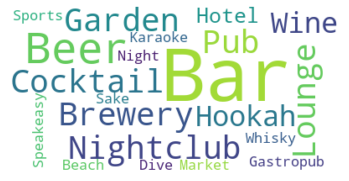

In [21]:
stopwords = set(STOPWORDS)
print('There are {} uniques categories.'.format(len(india_venues['Venue Category'].unique())))
print(india_venues['Venue Category'].unique().tolist())
s = str(india_venues['Venue Category'].unique())
s = s.replace('[','')
s = s.replace(']','')
s = s.replace("'",'')

# instantiate a word cloud object
venue_wc = WordCloud(
    background_color='white',
    max_words=100,
    stopwords=stopwords
)

# generate the word cloud
venue_wc.generate(s)

# display the word cloud
plt.imshow(venue_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [22]:
# one hot encoding
india_onehot = pd.get_dummies(india_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
india_onehot['City'] = india_venues['City'] 

# move city column to the first column
fixed_columns = [india_onehot.columns[-1]] + list(india_onehot.columns[:-1])
india_onehot = india_onehot[fixed_columns]

print(india_onehot.head())


     City  Bar  Beach Bar  Beer Bar  Beer Garden  Brewery  Cocktail Bar  \
0  Mumbai    1          0         0            0        0             0   
1  Mumbai    1          0         0            0        0             0   
2  Mumbai    0          0         0            0        1             0   
3  Mumbai    0          0         0            0        0             0   
4  Mumbai    1          0         0            0        0             0   

   Dive Bar  Gastropub  Hookah Bar  ...  Karaoke Bar  Lounge  Night Market  \
0         0          0           0  ...            0       0             0   
1         0          0           0  ...            0       0             0   
2         0          0           0  ...            0       0             0   
3         0          0           0  ...            0       1             0   
4         0          0           0  ...            0       0             0   

   Nightclub  Pub  Sake Bar  Speakeasy  Sports Bar  Whisky Bar  Wine Bar  
0    

In [23]:
india_grouped = india_onehot.groupby('City').mean().reset_index()

In [24]:
num_top_venues = 5

for ci in india_grouped['City']:
    #print("----"+city+"----")
    temp = india_grouped[india_grouped['City'] == ci].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = india_grouped['City']

for ind in np.arange(india_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(india_grouped.iloc[ind, :], num_top_venues)

In [26]:
print(city_venues_sorted.head())

         City 1st Most Common Venue 2nd Most Common Venue  \
0        Agra                   Bar                Lounge   
1   Ahmedabad             Hotel Bar             Speakeasy   
2   Allahabad                   Bar             Hotel Bar   
3    Amritsar                   Bar              Beer Bar   
4  Aurangabad                   Bar                Lounge   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0             Hotel Bar                   Pub            Sports Bar   
1             Nightclub                Lounge            Hookah Bar   
2            Hookah Bar                   Pub             Gastropub   
3             Hotel Bar                Lounge               Brewery   
4               Brewery              Dive Bar             Gastropub   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0             Speakeasy              Dive Bar             Beach Bar   
1             Gastropub             Beach Bar              Beer 

# The wordcloud creation, data cleaning looks encouraging. Now lets create and run our          # cluster algorithm to cluster the cities.
# Kindly remember that clusters formed here will be the exact SAME as in the report as the
# algorithm is the same and watertight BUT the order of the clusters may be different (0 can     # become 3) as I will be re running the same code before submission.

In [40]:
#Run k-means to cluster the city into 5 clusters.

# set number of clusters
kclusters = 5

india_grouped_clustering = india_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(india_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_[0:10])

[2 4 2 2 2 4 4 4 4 2]


In [43]:
#Let's create a new dataframe that includes the cluster as well as the top 10 venues for each city.
# add clustering labels
city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

india_merged = city_data

# merge india_grouped with india_data to add latitude/longitude for each neighborhood
india_merged = india_merged.join(city_venues_sorted.set_index('City'), on='City')
#india_merged = india_merged.dropna() #dropping the null values in columns as they have little/no effect on our cluster

print(india_merged.head())

        City Population   Latitude  Longitude  Cluster Labels  \
0     Mumbai   12442373  19.075990  72.877393               2   
1      Delhi   11007835  28.651718  77.221939               2   
2  Bangalore    8436675  12.979120  77.591300               4   
3  Hyderabad    6809970  17.360589  78.474061               4   
4  Ahmedabad    5570585  23.021624  72.579707               4   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                   Bar                Lounge                   Pub   
1                   Bar                Lounge                   Pub   
2               Brewery                Lounge                   Pub   
3                Lounge             Hotel Bar             Nightclub   
4             Hotel Bar             Speakeasy             Nightclub   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0               Brewery              Beer Bar             Nightclub   
1           Beer Garden          Cocktai

In [44]:
#Now lets visualize the clusters

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(india_merged['Latitude'], india_merged['Longitude'], india_merged['City'], india_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    #print(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Very interesting isn't it. Now let us show the indiviual clusters to ensure readibility and proof
# We have also included a map containing our recommended cluster as our project outcome.
# Please read the report to understand the other important cluster also alongwith its                 # comparision with the recommended one.

In [34]:
#Cluster 
print(india_merged.loc[india_merged['Cluster Labels'] == 0, india_merged.columns[[0] + list(range(5, india_merged.shape[1]))]])

        City 1st Most Common Venue 2nd Most Common Venue  \
21  Ludhiana                   Bar             Gastropub   
27    Rajkot                   Bar              Sake Bar   
30  Varanasi                   Bar                   Pub   
31  Srinagar                   Bar            Whisky Bar   
35      Navi                   Bar            Whisky Bar   
43   Madurai                   Bar          Cocktail Bar   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
21            Hookah Bar            Whisky Bar             Beach Bar   
27               Brewery            Hookah Bar             Beach Bar   
30              Beer Bar               Brewery             Gastropub   
31             Beach Bar              Beer Bar           Beer Garden   
35             Beach Bar              Beer Bar           Beer Garden   
43               Brewery              Wine Bar             Hotel Bar   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
21

In [31]:
#Cluster 
print(india_merged.loc[india_merged['Cluster Labels'] == 1, india_merged.columns[[0] + list(range(5, india_merged.shape[1]))]])

      City 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
24  Ranchi             Hotel Bar                Lounge            Hookah Bar   
45    Kota             Hotel Bar            Whisky Bar             Beach Bar   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
24             Beach Bar              Beer Bar           Beer Garden   
45              Beer Bar           Beer Garden               Brewery   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
24               Brewery          Cocktail Bar              Dive Bar   
45          Cocktail Bar              Dive Bar             Gastropub   

   10th Most Common Venue  
24              Gastropub  
45             Hookah Bar  


In [32]:
#Cluster 
print(india_merged.loc[india_merged['Cluster Labels'] == 2, india_merged.columns[[0] + list(range(5, india_merged.shape[1]))]])

               City 1st Most Common Venue 2nd Most Common Venue  \
0            Mumbai                   Bar                Lounge   
1             Delhi                   Bar                Lounge   
11           Kanpur                   Bar            Hookah Bar   
14            Thane                   Bar                   Pub   
16    Visakhapatnam                   Bar           Beer Garden   
18            Patna             Hotel Bar                   Pub   
22             Agra                   Bar                Lounge   
23           Nashik              Wine Bar                Lounge   
26           Meerut                   Bar            Hookah Bar   
28  Kalyan-Dombivli                   Bar                Lounge   
29      Vasai-Virar                   Bar            Hookah Bar   
32       Aurangabad                   Bar                Lounge   
33          Dhanbad                   Bar                Lounge   
34         Amritsar                   Bar              Beer Ba

In [33]:
#Cluster 
print(india_merged.loc[india_merged['Cluster Labels'] == 3, india_merged.columns[[0] + list(range(5, india_merged.shape[1]))]])

        City 1st Most Common Venue 2nd Most Common Venue  \
38   Gwalior                   Pub             Gastropub   
39  Jabalpur                   Pub             Nightclub   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
38              Wine Bar            Hookah Bar             Beach Bar   
39              Wine Bar            Hookah Bar             Beach Bar   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
38              Beer Bar           Beer Garden               Brewery   
39              Beer Bar           Beer Garden               Brewery   

   9th Most Common Venue 10th Most Common Venue  
38          Cocktail Bar               Dive Bar  
39          Cocktail Bar               Dive Bar  


In [45]:
#Cluster 
print(india_merged.loc[india_merged['Cluster Labels'] == 4, india_merged.columns[[0] + list(range(5, india_merged.shape[1]))]])


                City 1st Most Common Venue 2nd Most Common Venue  \
2          Bangalore               Brewery                Lounge   
3          Hyderabad                Lounge             Hotel Bar   
4          Ahmedabad             Hotel Bar             Speakeasy   
5            Chennai                Lounge                   Bar   
6            Kolkata             Nightclub                   Pub   
7              Surat            Sports Bar          Cocktail Bar   
8               Pune                   Pub                Lounge   
9             Jaipur                Lounge                   Bar   
10           Lucknow            Hookah Bar                Lounge   
12            Nagpur                Lounge                   Bar   
13            Indore                Lounge            Hookah Bar   
15            Bhopal             Hotel Bar                   Pub   
17  Pimpri-Chinchwad                   Pub                Lounge   
19          Vadodara                Lounge      

In [46]:
#Now lets visualize the recommended cluster (cluster 4)

# create map
map_clusters4 = folium.Map(location=[latitude, longitude], zoom_start=5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(india_merged['Latitude'], india_merged['Longitude'], india_merged['City'], india_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    #print(cluster)
    if cluster == 4:
        folium.CircleMarker(
			[lat, lon],
			radius=5,
			popup=label,
			color=rainbow[int(cluster)],
			fill=True,
			fill_color=rainbow[int(cluster)],
			fill_opacity=0.7).add_to(map_clusters4)
       
#map_clusters
map_clusters4

# Thus we come to the end of our code. Thank you for reviewing it. If you have any comments
# to share, kindly write them in the submission box in the peer review process.